In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2

from PIL import Image
import os

2024-05-31 16:41:36.950842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:41:36.950963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:41:37.082135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def classify_image_class(image_path, model):
    # Load the image
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Normalize the image
    img_array = img_array / 255.0

    # Get the predicted probabilities for each class
    predictions = model.predict(img_array)

    # Get the class with the highest probability index
    predicted_class_index = np.argmax(predictions[0])

    # Extract class names from the directory structure
    class_names = sorted(os.listdir(train_dir))

    return class_names[predicted_class_index], predicted_class_index,predictions

In [3]:
def show_cm(model):
    # List to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    for images, labels in test_ds:
        # Make predictions
        predictions = model.predict(images)
        # Get predicted labels
        predicted_labels.extend(np.argmax(predictions, axis=1))
        # Get true labels
        true_labels.extend(labels.numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=class_names.values(), 
                yticklabels=class_names.values(), 
                cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [5]:
img_height = 128
img_width = 128
batch_size = 32

In [6]:
train_ds = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [7]:
class_list = sorted(os.listdir(train_dir))
print(class_list)
class_names = {i: class_list[i] for i in range(len(class_list))}
class_names

['NORMAL', 'PNEUMONIA']


{0: 'NORMAL', 1: 'PNEUMONIA'}

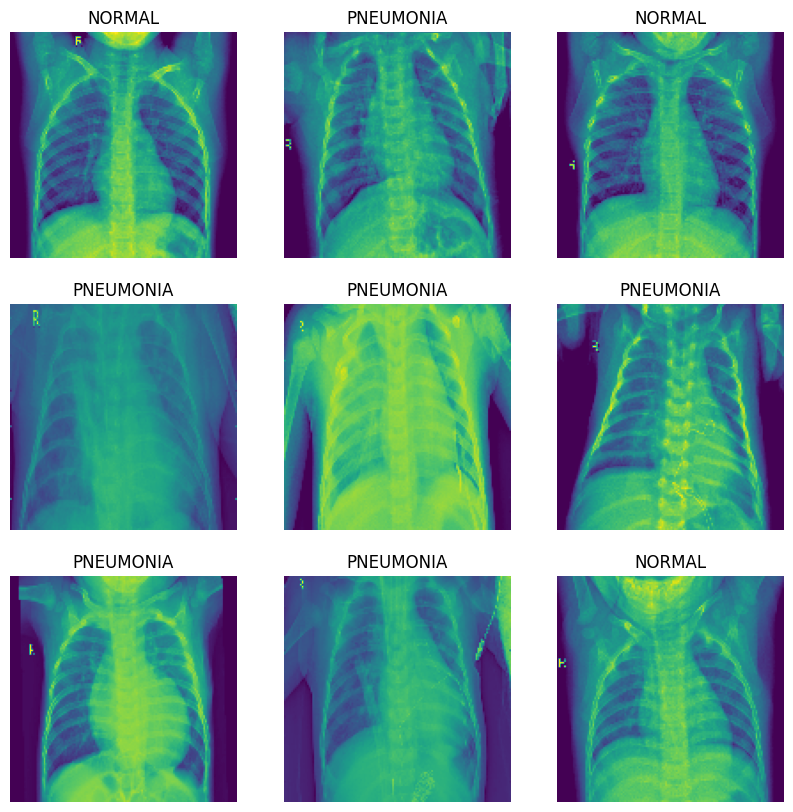

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
model_1 = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [11]:
model_1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(), #from_logits=True),
    metrics=['accuracy']
)

In [12]:
epochs = 10

In [13]:
model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10


2024-05-31 16:41:56.578330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.39151, expected 2.7295
2024-05-31 16:41:56.578387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.36773, expected 2.70572
2024-05-31 16:41:56.578402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.08268, expected 2.42067
2024-05-31 16:41:56.578416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.1679, expected 2.50589
2024-05-31 16:41:56.578446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.96544, expected 2.30343
2024-05-31 16:41:56.578457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.78427, expected 2.12226
2024-05-31 16:41:56.578468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.73395, expected 2.07194
2024-05-31 16:41:56.578478: E external/local_xla/xla/serv

  7/163 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7636 - loss: 0.7059 

I0000 00:00:1717173719.149405      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8252 - loss: 0.4029

2024-05-31 16:42:16.040331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47628: 4.20935, expected 3.49544
2024-05-31 16:42:16.040396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47629: 3.48288, expected 2.76897
2024-05-31 16:42:16.040406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47630: 3.97554, expected 3.26164
2024-05-31 16:42:16.040414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47631: 3.65741, expected 2.9435
2024-05-31 16:42:16.040421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47632: 3.23787, expected 2.52397
2024-05-31 16:42:16.040439: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47633: 3.11375, expected 2.39984
2024-05-31 16:42:16.040447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 47634: 2.68378, expected 1.96988
2024-05-31 16:42:16.040455: 

163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.8256 - loss: 0.4020 - val_accuracy: 0.9375 - val_loss: 0.3989
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9510 - loss: 0.1224 - val_accuracy: 1.0000 - val_loss: 0.3551
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9596 - loss: 0.1033 - val_accuracy: 1.0000 - val_loss: 0.2817
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9640 - loss: 0.0975 - val_accuracy: 0.8125 - val_loss: 0.2843
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9679 - loss: 0.0851 - val_accuracy: 0.8750 - val_loss: 0.2546
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9664 - loss: 0.0952 - val_accuracy: 0.9375 - val_loss: 0.2199
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9724 - loss: 0.0683 - val_accuracy: 0.8125 - val_loss: 0.2906
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9694 - loss: 0.0793 - val_accuracy: 0.8125 - v

In [14]:
model_loss_accuracy = model_1.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7943 - loss: 1.1197


In [15]:
print(model_1.get_compile_config())
print(f"{model_loss_accuracy=}")

{'optimizer': 'adam', 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'name': 'sparse_categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'ignore_class': None}, 'registered_name': None}, 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}
model_loss_accuracy=[1.0175641775131226, 0.8092948794364929]


In [16]:
print(f"{model_loss_accuracy=}")

model_loss_accuracy=[1.0175641775131226, 0.8092948794364929]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


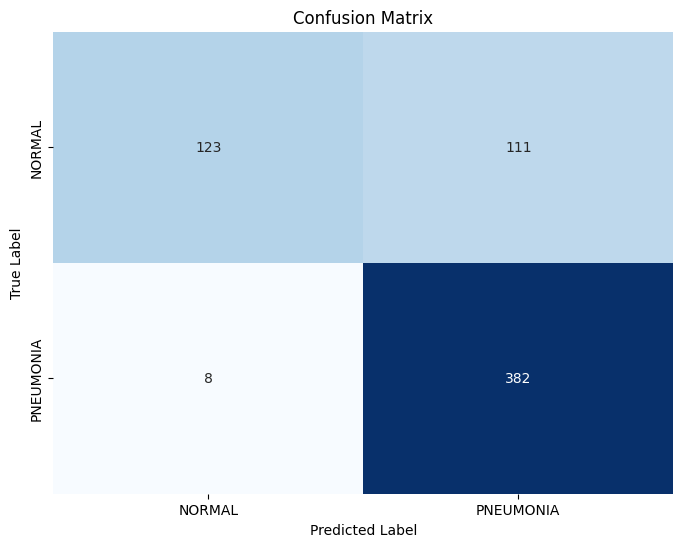

In [17]:
show_cm(model_1)

In [18]:
# model_1.save('cnn_pneumo_v1.h5')

## Applying model

Keras preprocessing

In [19]:
# def classify_image_class(image_path, model):
#     # Load the image
#     img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(img_height, img_width))
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)  # Create a batch

#     # Normalize the image
#     img_array = img_array / 255.0

#     # Get the predicted probabilities for each class
#     predictions = model.predict(img_array)

#     # Get the class with the highest probability index
#     predicted_class_index = np.argmax(predictions[0])

#     # Extract class names from the directory structure
#     class_names = sorted(os.listdir(train_dir))

#     return class_names[predicted_class_index], predicted_class_index,predictions


### Testing the predictor with images

In [20]:
normal_img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
pneumo_img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg'

In [21]:
image_path = normal_img_path  # Specify the path to your image
predicted_class = classify_image_class(image_path, model_1)
print("Predicted class:", predicted_class)

2024-05-31 16:42:30.384446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.1741, expected 2.5385
2024-05-31 16:42:30.384493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.24319, expected 2.60759
2024-05-31 16:42:30.384506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.92487, expected 3.28927
2024-05-31 16:42:30.384517: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.25447, expected 2.61887
2024-05-31 16:42:30.384527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.2287, expected 2.5931
2024-05-31 16:42:30.384538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.2258, expected 2.5902
2024-05-31 16:42:30.384551: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.9688, expected 2.3332
2024-05-31 16:42:30.384564: E external/local_xla/xla/service/gp

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Predicted class: ('PNEUMONIA', 1, array([[1.0468993e-04, 9.9989533e-01]], dtype=float32))


# Experimentation with model architecture

In [22]:
model_2 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

epochs = 20
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7401 - loss: 5.1387 - val_accuracy: 0.6250 - val_loss: 0.7413
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9282 - loss: 0.1853 - val_accuracy: 0.7500 - val_loss: 0.6134
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9438 - loss: 0.1501 - val_accuracy: 0.8125 - val_loss: 0.3866
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9456 - loss: 0.1393 - val_accuracy: 0.9375 - val_loss: 0.2103
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9474 - loss: 0.1364 - val_accuracy: 0.9375 - val_loss: 0.2374
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9608 - loss: 0.1196 - val_accuracy: 0.9375 - val_loss: 0.1998
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9657 - loss: 0.0960 - val_accuracy: 1.0000 - val_loss: 0.1304
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9633 - loss: 0.0909 - val_accuracy: 0

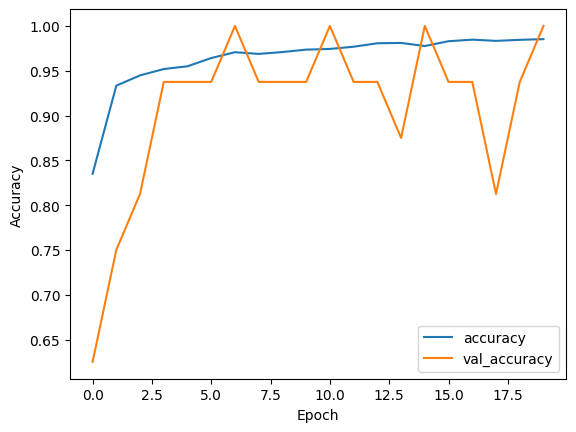

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
image_path = normal_img_path  # Specify the path to your image
predicted_class = classify_image_class(image_path, model_2)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Predicted class: ('PNEUMONIA', 1, array([[0.4942544, 0.5057456]], dtype=float32))


In [26]:
image_path = pneumo_img_path  # Specify the path to your image
predicted_class = classify_image_class(image_path, model_2)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: ('PNEUMONIA', 1, array([[0.48048925, 0.5195107 ]], dtype=float32))


In [27]:
model_loss_accuracy = model_2.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7996 - loss: 1.2472


In [28]:
# model_2.save('cnn_pneumo_v2.h5')

# Visualization of misclassified images

In [29]:
def show_misclassified(model):
# List to store misclassified images
    misclassified_images = []

    # Iterate through the test dataset
    for images, labels in test_ds:
        # Make predictions
        predictions = model.predict(images)
        # Get predicted labels
        predicted_labels = np.argmax(predictions, axis=1)
        # Compare predicted labels with true labels
        for i in range(len(labels)):
            if predicted_labels[i] != labels[i]:
                # If predicted label is different from true label, store the image and labels
                misclassified_images.append((images[i], labels[i].numpy(), predicted_labels[i]))

    # Dictionary to map numerical labels to class names
    class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}

    # Visualize some of the misclassified images with class names
    plt.figure(figsize=(10, 10))
    for i in range(min(len(misclassified_images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(misclassified_images[i][0].numpy().squeeze(), cmap='gray')  # Assuming images are grayscale
        true_label = class_names[misclassified_images[i][1]]
        predicted_label = class_names[misclassified_images[i][2]]
        plt.title(f'True: {true_label}, \nPredicted: {predicted_label}')
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


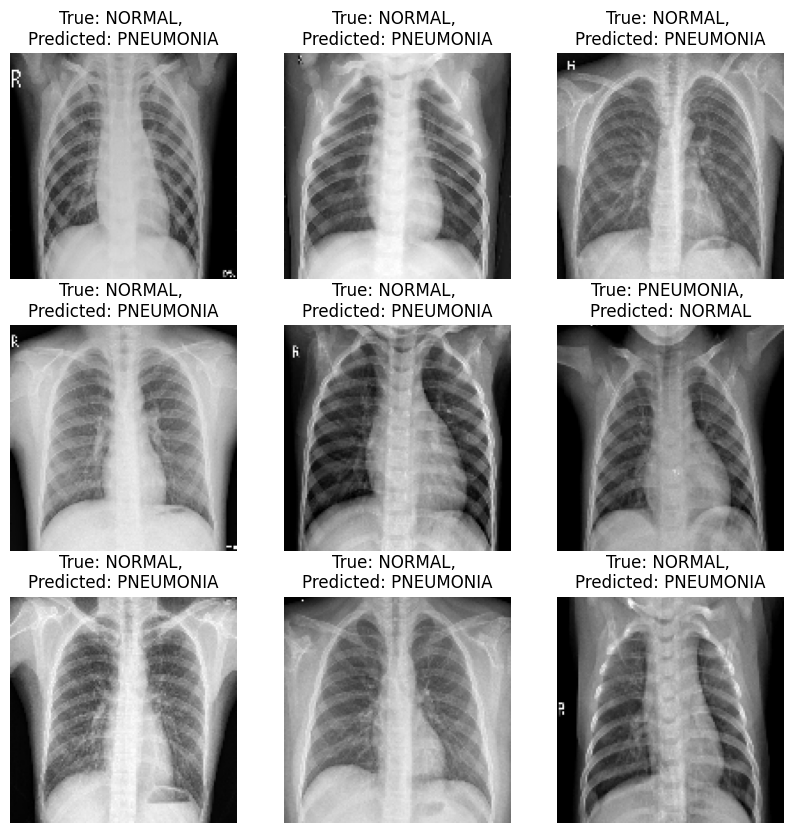

In [30]:
show_misclassified(model_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


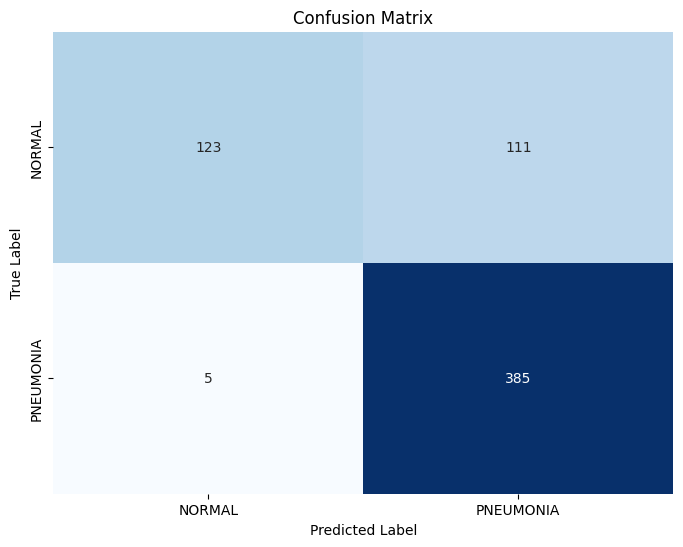

In [31]:
# Show confusion matrix
show_cm(model_2)

# Dealing with class imbalance

In [32]:
# Check class distribution in the training set
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))

print("Number of NORMAL images:", num_normal)
print("Number of PNEUMONIA images:", num_pneumonia)

Number of NORMAL images: 1341
Number of PNEUMONIA images: 3875


In [33]:
class_weights = {0: 1, 1: 3}

In [34]:
model_3 = tf.keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_3.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

epochs = 20
history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7800 - loss: 5.9573 - val_accuracy: 0.7500 - val_loss: 0.8059
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9045 - loss: 0.2945 - val_accuracy: 0.5625 - val_loss: 0.7454
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9255 - loss: 0.2576 - val_accuracy: 0.8125 - val_loss: 0.3711
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9307 - loss: 0.2295 - val_accuracy: 0.8125 - val_loss: 0.5213
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9430 - loss: 0.2003 - val_accuracy: 0.8125 - val_loss: 0.3643
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9503 - loss: 0.1792 - val_accuracy: 0.8125 - val_loss: 0.3460
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9653 - loss: 0.1527 - val_accuracy: 0.7500 - val_loss: 0.5516
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9604 - loss: 0.1467 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


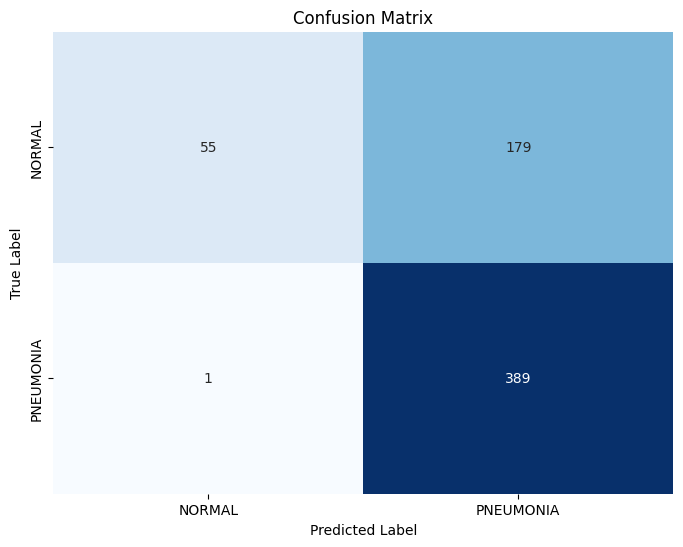

In [36]:
show_cm(model_3)

In [37]:
image_path = normal_img_path  # Specify the path to your image
predicted_class = classify_image_class(image_path, model_3)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Predicted class: ('NORMAL', 0, array([[0.50788903, 0.492111  ]], dtype=float32))


In [38]:
image_path = pneumo_img_path  # Specify the path to your image
predicted_class = classify_image_class(image_path, model_3)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: ('PNEUMONIA', 1, array([[0.4933856, 0.5066144]], dtype=float32))


In [39]:
model_loss_accuracy = model_3.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6739 - loss: 2.3311


In [40]:
# model_3.save('cnn_pneumo_v3.h5')

# Model 4

In [41]:
# Data augmentation
# data_augmentation = tf.keras.Sequential([
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomFlip("horizontal"),
#     layers.RandomContrast(0.2),
# ])

In [42]:
model_4 = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [43]:
class_weights = {0: 1, 1: 3}

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_4.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

epochs = 20
history = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7178 - loss: 3.7644 - val_accuracy: 0.6250 - val_loss: 0.9576
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7591 - loss: 0.7005 - val_accuracy: 0.5000 - val_loss: 1.5425
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7572 - loss: 0.6091 - val_accuracy: 0.6250 - val_loss: 1.0224
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7851 - loss: 0.5495 - val_accuracy: 0.6250 - val_loss: 1.3026
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7866 - loss: 0.5271 - val_accuracy: 0.6875 - val_loss: 0.6789
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7998 - loss: 0.5105 - val_accuracy: 0.6250 - val_loss: 1.0581
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7974 - loss: 0.4873 - val_accuracy: 0.6250 - val_loss: 1.2892
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8191 - loss: 0.4674 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


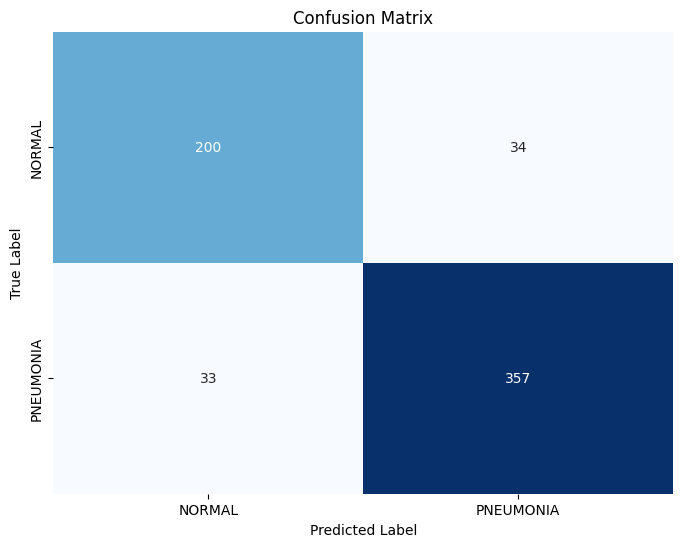

In [45]:
show_cm(model_4)

In [46]:
image_path = normal_img_path
predicted_class = classify_image_class(image_path, model_4)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted class: ('PNEUMONIA', 1, array([[0.46438074, 0.5356193 ]], dtype=float32))


In [47]:
image_path = pneumo_img_path
predicted_class = classify_image_class(image_path, model_4)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: ('PNEUMONIA', 1, array([[0.46237615, 0.5376239 ]], dtype=float32))


In [48]:
model_loss_accuracy = model_4.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8801 - loss: 0.3360


In [49]:
# model_4.save('cnn_pneumo_v4.h5')

# Confustion Matrices for all models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


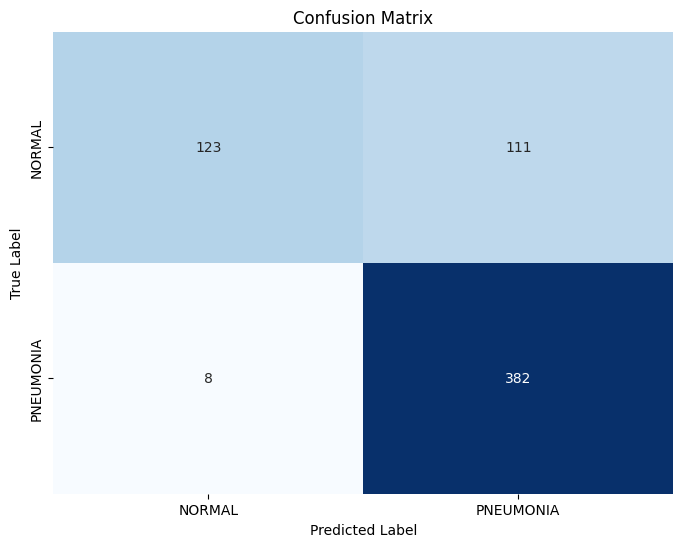

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


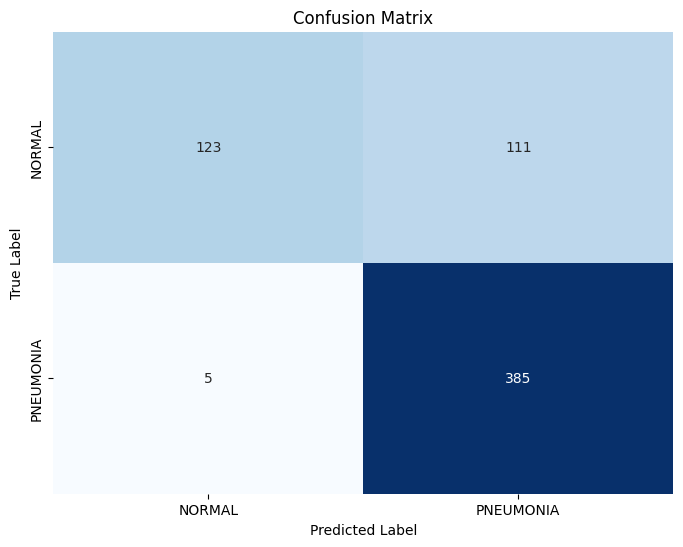

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


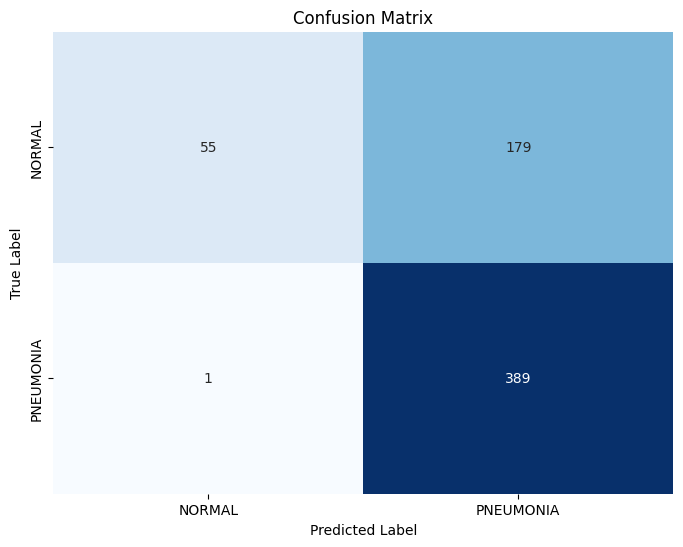

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


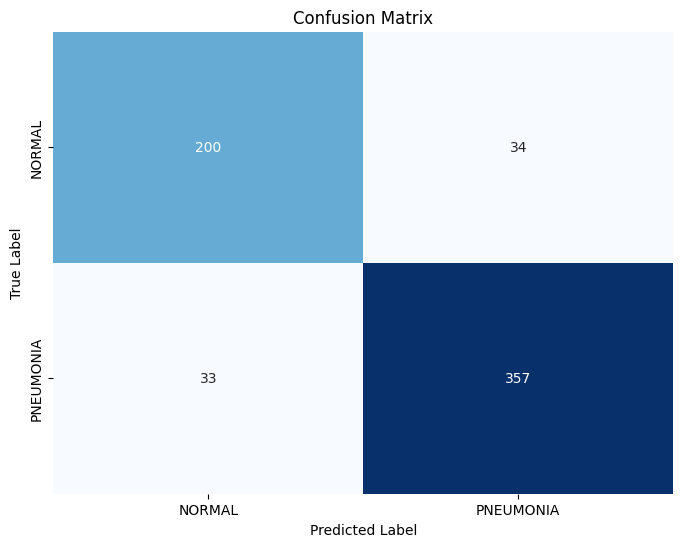

In [50]:
show_cm(model_1)
show_cm(model_2)
show_cm(model_3)
show_cm(model_4)

# Test same images for all models

In [51]:
normal_list = [
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0033-0001-0001.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0037-0001.jpeg'
]

pneumo_list = [
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_485.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg',
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_527.jpeg'
]

In [52]:
models_list = [model_1, model_2, model_3, model_4]


# image_path = pneumo_img_path
# predicted_class = classify_image_class(image_path, model_4)
# print("Predicted class:", predicted_class)

In [53]:
for i, m in enumerate(models_list):
    print(f"Model {i+1}:")
    for img in normal_list:
        predicted_class = classify_image_class(img, m)
        print(f"True: NORMAL\tPredicted: {predicted_class[0]}")
    for img in pneumo_list:
        predicted_class = classify_image_class(img, m)
        print(f"True: PNEUMONIA\tPredicted: {predicted_class[0]}")
    print("")
        

Model 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True: PNEUMONIA	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True: PNEUMONIA	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True: PNEUMONIA	Predicted: PNEUMONIA

Model 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True: NORMAL	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True: PNEUMONIA	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True: PNEUMONIA	Predicted: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True: PNEUMONIA	Predicted: PNEUMONIA

Model 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True: NORMAL	Predicted: NORMAL
1/1 ━━━━━━━━━━━━━━━━

# Plot the training process

In [54]:
# Loss plot
def plot_acc_loss(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
    plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Summary
The best performing model is the __model_4__ which has the less false positives

In [55]:
# Save first 3 models
model_1.save('cnn_pneumo_v1.h5')
model_2.save('cnn_pneumo_v2.h5')
model_3.save('cnn_pneumo_v3.h5')

In [56]:
# Save the model # 4
model_4.save('cnn_pneumo_v4.keras')

In [57]:
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 128, 128, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,912,968 (37.81 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,608,646 (25.21 MB)

In [58]:
# Check the saved model_4
model_4_loaded = load_model('cnn_pneumo_v4.keras')
model_4_loaded.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 128, 128, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,912,968 (37.81 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,608,646 (25.21 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


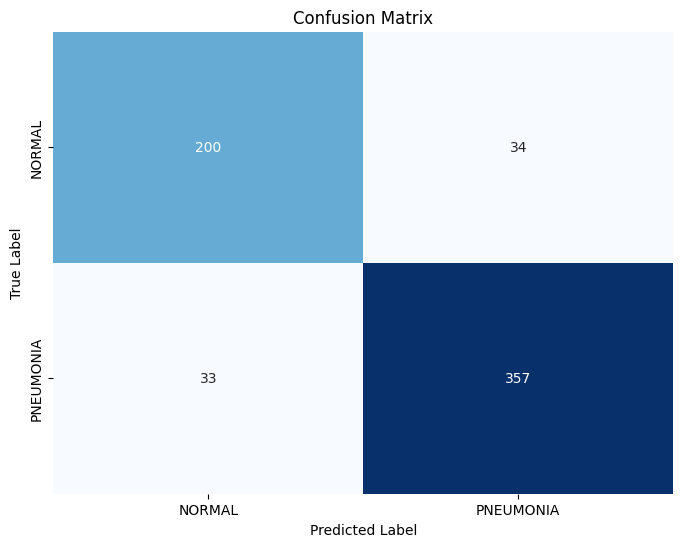

In [59]:
# verify the confusion matrix for model_4_loaded
show_cm(model_4_loaded)

In [60]:
# Save model_4 architecture and weights
model_4.save_weights('cnn_pneumo_v4.weights.h5')

model_4_json = model_4.to_json()
with open('cnn_pneumo_v4.json', 'w') as f:
    f.write(model_4_json)

In [61]:
!ls '/kaggle/working/'

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


__notebook__.ipynb  cnn_pneumo_v3.h5	 cnn_pneumo_v4.weights.h5
cnn_pneumo_v1.h5    cnn_pneumo_v4.json
cnn_pneumo_v2.h5    cnn_pneumo_v4.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


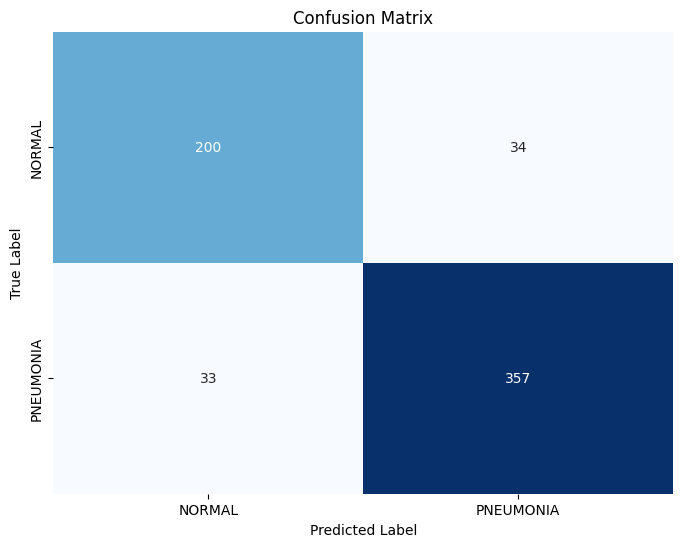

In [62]:
# Check loading architecture and weights
with open('cnn_pneumo_v4.json', 'r') as f:
    loaded_json_string = f.read()
    
model_4_j_w = model_from_json(loaded_json_string)
model_4_j_w.load_weights('cnn_pneumo_v4.weights.h5')

show_cm(model_4_j_w)

In [63]:
from IPython.display import FileLink
FileLink(r'cnn_pneumo_v4.keras')

/kaggle/working/cnn_pneumo_v4.keras

In [64]:
FileLink(r'cnn_pneumo_v4.json')

/kaggle/working/cnn_pneumo_v4.json

In [65]:
FileLink(r'cnn_pneumo_v4.weights.h5')

/kaggle/working/cnn_pneumo_v4.weights.h5